In [1]:
import spacy
import gensim
import pandas as pd
import nltk
import numpy as np
import seaborn as sn
import re
import string
import xgboost as xgb

from xgboost import XGBClassifier
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from gensim.models.fasttext import FastText
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from MeanVectorizer import MeanEmbeddingVectorizer
from sklearn.utils import resample

nlp = spacy.blank('id')
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\egapa\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
df = pd.read_excel("pemilu.xlsx")
df.head()

,id_pembuat,id_status,nama_pembuat,teks_status,gambar_status,url_komentar,waktu_status,id_komentar,id_user_komen,komentar,waktu_komen,label
0,23383061178,23383061178_10152076252911179,Bang Nafie,Saya banyak belajar prinsip-prinsip kehidupan ...,https://fbexternal-a.akamaihd.net/safe_image.p...,https://www.facebook.com/23383061178/posts/101...,2014-06-05 03:54:47,10152076252516179_10152076253441179,794948677210695,Oke pak boss!!,2014-06-05 03:55:15,positif
1,23383061178,23383061178_10152076252911179,Sumy Kakasyi Suhaimy,Saya banyak belajar prinsip-prinsip kehidupan ...,https://fbexternal-a.akamaihd.net/safe_image.p...,https://www.facebook.com/23383061178/posts/101...,2014-06-05 03:54:47,10152076252516179_10152076253906179,355122887988412,Jangan dusta,2014-06-05 03:55:29,negatif
2,23383061178,23383061178_10152076252911179,Roberto Red,Saya banyak belajar prinsip-prinsip kehidupan ...,https://fbexternal-a.akamaihd.net/safe_image.p...,https://www.facebook.com/23383061178/posts/101...,2014-06-05 03:54:47,10152076252516179_10152076253996179,297825977080553,PROBOWO is the WINNER of PEMILU 2014,2014-06-05 03:55:32,positif
3,23383061178,23383061178_10152076252911179,Sugiarman Arman,Saya banyak belajar prinsip-prinsip kehidupan ...,https://fbexternal-a.akamaihd.net/safe_image.p...,https://www.facebook.com/23383061178/posts/101...,2014-06-05 03:54:47,10152076252516179_10152076254066179,298708870333739,ilmu padi,2014-06-05 03:55:35,netral
4,23383061178,23383061178_10152076252911179,Rio Corps Taruna,Saya banyak belajar prinsip-prinsip kehidupan ...,https://fbexternal-a.akamaihd.net/safe_image.p...,https://www.facebook.com/23383061178/posts/101...,2014-06-05 03:54:47,10152076252516179_10152076254216179,1523715244533780,Hidup Pak Prabowo ..,2014-06-05 03:55:42,positif


In [3]:
komentar = df['komentar'].astype(str)

# Huruf kecil
komentar = komentar.apply(lambda x: x.lower())

# Hapus URL
komentar = komentar.apply(lambda x: re.sub(r'^https?:\/\/.*[\r\n]*', '', x, flags=re.MULTILINE))

# Hapus angka
komentar = komentar.apply(lambda x: re.sub(r"\d", "", x))

# Hapus tanda baca
komentar = komentar.apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))

# Hapus diluar alphabet dan numeric
komentar = komentar.apply(lambda x: re.sub(r'([^\s\w]|_)+', '', x))

# Tokenizing data
komentar = komentar.apply(lambda x: nltk.tokenize.word_tokenize(x))

df['komentar'] = komentar
df

,id_pembuat,id_status,nama_pembuat,teks_status,gambar_status,url_komentar,waktu_status,id_komentar,id_user_komen,komentar,waktu_komen,label
0,23383061178,23383061178_10152076252911179,Bang Nafie,Saya banyak belajar prinsip-prinsip kehidupan ...,https://fbexternal-a.akamaihd.net/safe_image.p...,https://www.facebook.com/23383061178/posts/101...,2014-06-05 03:54:47,10152076252516179_10152076253441179,794948677210695,"[oke, pak, boss]",2014-06-05 03:55:15,positif
1,23383061178,23383061178_10152076252911179,Sumy Kakasyi Suhaimy,Saya banyak belajar prinsip-prinsip kehidupan ...,https://fbexternal-a.akamaihd.net/safe_image.p...,https://www.facebook.com/23383061178/posts/101...,2014-06-05 03:54:47,10152076252516179_10152076253906179,355122887988412,"[jangan, dusta]",2014-06-05 03:55:29,negatif
2,23383061178,23383061178_10152076252911179,Roberto Red,Saya banyak belajar prinsip-prinsip kehidupan ...,https://fbexternal-a.akamaihd.net/safe_image.p...,https://www.facebook.com/23383061178/posts/101...,2014-06-05 03:54:47,10152076252516179_10152076253996179,297825977080553,"[probowo, is, the, winner, of, pemilu]",2014-06-05 03:55:32,positif
3,23383061178,23383061178_10152076252911179,Sugiarman Arman,Saya banyak belajar prinsip-prinsip kehidupan ...,https://fbexternal-a.akamaihd.net/safe_image.p...,https://www.facebook.com/23383061178/posts/101...,2014-06-05 03:54:47,10152076252516179_10152076254066179,298708870333739,"[ilmu, padi]",2014-06-05 03:55:35,netral
4,23383061178,23383061178_10152076252911179,Rio Corps Taruna,Saya banyak belajar prinsip-prinsip kehidupan ...,https://fbexternal-a.akamaihd.net/safe_image.p...,https://www.facebook.com/23383061178/posts/101...,2014-06-05 03:54:47,10152076252516179_10152076254216179,1523715244533780,"[hidup, pak, prabowo]",2014-06-05 03:55:42,positif
...,...,...,...,...,...,...,...,...,...,...,...,...
3359,249750628565406,249750628565406_276917339182068,Anita Rizkia,"Dukungan anda semua adalah amanah, dan apapun ...",https://fbexternal-a.akamaihd.net/safe_image.p...,https://www.facebook.com/249750628565406/posts...,2014-07-09 03:19:51,276891429184659_276927652514370,967613349931842,"[salam, jari]",2014-07-09 03:25:45,positif
3360,249750628565406,249750628565406_276917339182068,Ari Bin Abu Bakar,"Dukungan anda semua adalah amanah, dan apapun ...",https://fbexternal-a.akamaihd.net/safe_image.p...,https://www.facebook.com/249750628565406/posts...,2014-07-09 03:19:51,276891429184659_276918865848582,773356856051191,"[jujur, ketika, ane, membuka, surat, suara, ta...",2014-07-09 03:21:40,negatif
3361,249750628565406,249750628565406_276917339182068,Agek James,"Dukungan anda semua adalah amanah, dan apapun ...",https://fbexternal-a.akamaihd.net/safe_image.p...,https://www.facebook.com/249750628565406/posts...,2014-07-09 03:19:51,276891429184659_276921042515031,710343512387954,"[bapak, jokowi, kami, semua, rakyat, ingin, ba...",2014-07-09 03:24:02,positif
3362,249750628565406,249750628565406_276917339182068,ChairudinDr Humaniora,"Dukungan anda semua adalah amanah, dan apapun ...",https://fbexternal-a.akamaihd.net/safe_image.p...,https://www.facebook.com/249750628565406/posts...,2014-07-09 03:19:51,276891429184659_276931322514003,10152763210314600,"[tanda, alam, pemilu, day, on, juli, hasil, je...",2014-07-09 03:26:36,positif


In [4]:
df['label'].value_counts()

positif    2912
negatif     332
netral      120
Name: label, dtype: int64

In [5]:
df = df[df.komentar.astype(bool)]

df_pos = df[df['label'] == 'positif']
X_pos_text = df_pos['komentar']
y_pos_label = df_pos['label']

df_neg = df[df['label'] == 'negatif']
X_neg_text = df_neg['komentar']
y_neg_label = df_neg['label']

df_net = df[df['label'] == 'netral']
X_net_text = df_net['komentar']
y_net_label = df_net['label']

In [6]:
X_pos_train, X_pos_test, y_pos_train, y_pos_test = train_test_split(X_pos_text, y_pos_label, test_size=0.2, random_state=1, stratify=y_pos_label)
X_neg_train, X_neg_test, y_neg_train, y_neg_test = train_test_split(X_neg_text, y_neg_label, test_size=0.2, random_state=1, stratify=y_neg_label)
X_net_train, X_net_test, y_net_train, y_net_test = train_test_split(X_net_text, y_net_label, test_size=0.2, random_state=1, stratify=y_net_label)

In [7]:
X_pos_train_down = resample(X_pos_train, replace=True, n_samples=int(len(X_net_train)))
y_pos_train_down = resample(y_pos_train, replace=True, n_samples=int(len(y_net_train)))

X_neg_train_down = resample(X_neg_train, replace=True, n_samples=int(len(X_net_train)))
y_neg_train_down = resample(y_neg_train, replace=True, n_samples=int(len(y_net_train)))

In [8]:
X_train = pd.concat([X_net_train, X_pos_train_down])
X_train = pd.concat([X_train, X_neg_train_down])
y_train = pd.concat([y_net_train, y_pos_train_down])
y_train = pd.concat([y_train, y_neg_train_down])

X_test = pd.concat([X_net_test, X_pos_test])
X_test = pd.concat([X_test, X_neg_test])
y_test = pd.concat([y_net_test, y_pos_test])
y_test = pd.concat([y_test, y_neg_test])

In [9]:
print(y_train.value_counts())

positif    88
negatif    88
netral     88
Name: label, dtype: int64


In [10]:
from gensim.models.fasttext import FastText
model = FastText.load_fasttext_format('../../../cc.id.300.bin')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `load_fasttext_format` (use load_facebook_vectors (to use pretrained embeddings) or load_facebook_model (to continue training with the loaded full model, more RAM) instead).
  


In [11]:
mean_vec_tr = MeanEmbeddingVectorizer(model)

In [12]:
X_train_vector = mean_vec_tr.transform(X_train)
X_test_vector = mean_vec_tr.transform(X_test)

In [13]:
lc = preprocessing.LabelEncoder()
lc.fit(y_train)

LabelEncoder()

In [14]:
y_train_enc = lc.transform(y_train)
y_test_enc = lc.transform(y_test)

In [15]:
train = xgb.DMatrix(X_train_vector,label=y_train_enc)
test = xgb.DMatrix(X_test_vector,label=y_test_enc)

In [16]:
param = {}

# Learning Rate:  0.01
# Gamma:  0.3
# Max Depth:  7
# Subsample:  0.4
# Colsample Bytree:  0.6
# Alpha:  0
# Lamda:  1.5
# Min Child Weight:  1
# Number of Trees:  1000

param['num_class']=len(set(y_train))
param['objective'] = 'multi:softmax'
param['learning_rate'] = 0.01
param['gamma'] = 0.3
param['max_depth'] = 7
param['subsample'] = 0.4
param['colsample_bytree'] = 0.6
param['reg_alpha'] = 0
param['reg_lambda'] = 1.5
param['min_child_weight'] = 1
num_round = 1000

watchlist = [(train, 'train'), (test, 'test')]
bst = xgb.train(param, train, num_round, watchlist)

[0]	train-merror:0.35985	test-merror:0.55239
[1]	train-merror:0.25000	test-merror:0.56138
[2]	train-merror:0.19697	test-merror:0.54940
[3]	train-merror:0.18182	test-merror:0.55838
[4]	train-merror:0.14773	test-merror:0.53144
[5]	train-merror:0.09849	test-merror:0.53743
[6]	train-merror:0.08712	test-merror:0.52994
[7]	train-merror:0.08712	test-merror:0.53144
[8]	train-merror:0.06061	test-merror:0.52545
[9]	train-merror:0.07576	test-merror:0.50898
[10]	train-merror:0.06439	test-merror:0.50748
[11]	train-merror:0.06818	test-merror:0.50898
[12]	train-merror:0.05682	test-merror:0.50150
[13]	train-merror:0.06818	test-merror:0.51497
[14]	train-merror:0.04167	test-merror:0.51347
[15]	train-merror:0.04546	test-merror:0.50299
[16]	train-merror:0.04546	test-merror:0.50599
[17]	train-merror:0.04546	test-merror:0.50449
[18]	train-merror:0.03788	test-merror:0.49850
[19]	train-merror:0.02652	test-merror:0.50299
[20]	train-merror:0.01894	test-merror:0.54341
[21]	train-merror:0.02652	test-merror:0.5314

[177]	train-merror:0.00379	test-merror:0.52395
[178]	train-merror:0.00379	test-merror:0.52545
[179]	train-merror:0.00379	test-merror:0.52844
[180]	train-merror:0.00379	test-merror:0.52844
[181]	train-merror:0.00379	test-merror:0.52096
[182]	train-merror:0.00379	test-merror:0.52096
[183]	train-merror:0.00379	test-merror:0.52096
[184]	train-merror:0.00379	test-merror:0.52096
[185]	train-merror:0.00379	test-merror:0.52246
[186]	train-merror:0.00379	test-merror:0.52395
[187]	train-merror:0.00379	test-merror:0.52246
[188]	train-merror:0.00379	test-merror:0.52395
[189]	train-merror:0.00379	test-merror:0.51796
[190]	train-merror:0.00379	test-merror:0.52096
[191]	train-merror:0.00379	test-merror:0.52246
[192]	train-merror:0.00379	test-merror:0.52096
[193]	train-merror:0.00379	test-merror:0.52096
[194]	train-merror:0.00379	test-merror:0.51946
[195]	train-merror:0.00379	test-merror:0.52096
[196]	train-merror:0.00379	test-merror:0.52246
[197]	train-merror:0.00379	test-merror:0.52096
[198]	train-m

[352]	train-merror:0.00379	test-merror:0.50599
[353]	train-merror:0.00379	test-merror:0.50748
[354]	train-merror:0.00379	test-merror:0.50748
[355]	train-merror:0.00379	test-merror:0.50748
[356]	train-merror:0.00379	test-merror:0.50748
[357]	train-merror:0.00379	test-merror:0.50748
[358]	train-merror:0.00379	test-merror:0.50449
[359]	train-merror:0.00379	test-merror:0.50449
[360]	train-merror:0.00379	test-merror:0.50449
[361]	train-merror:0.00379	test-merror:0.50449
[362]	train-merror:0.00379	test-merror:0.50599
[363]	train-merror:0.00379	test-merror:0.50748
[364]	train-merror:0.00379	test-merror:0.50599
[365]	train-merror:0.00379	test-merror:0.50748
[366]	train-merror:0.00379	test-merror:0.50599
[367]	train-merror:0.00379	test-merror:0.50299
[368]	train-merror:0.00379	test-merror:0.50599
[369]	train-merror:0.00379	test-merror:0.50299
[370]	train-merror:0.00379	test-merror:0.50299
[371]	train-merror:0.00379	test-merror:0.50150
[372]	train-merror:0.00379	test-merror:0.50299
[373]	train-m

[527]	train-merror:0.00379	test-merror:0.50000
[528]	train-merror:0.00379	test-merror:0.50000
[529]	train-merror:0.00379	test-merror:0.49850
[530]	train-merror:0.00379	test-merror:0.49850
[531]	train-merror:0.00379	test-merror:0.50150
[532]	train-merror:0.00379	test-merror:0.50150
[533]	train-merror:0.00379	test-merror:0.50000
[534]	train-merror:0.00379	test-merror:0.50000
[535]	train-merror:0.00379	test-merror:0.49850
[536]	train-merror:0.00379	test-merror:0.49850
[537]	train-merror:0.00379	test-merror:0.49701
[538]	train-merror:0.00379	test-merror:0.49551
[539]	train-merror:0.00379	test-merror:0.49850
[540]	train-merror:0.00379	test-merror:0.49850
[541]	train-merror:0.00379	test-merror:0.49701
[542]	train-merror:0.00379	test-merror:0.49551
[543]	train-merror:0.00379	test-merror:0.49850
[544]	train-merror:0.00379	test-merror:0.49850
[545]	train-merror:0.00379	test-merror:0.49850
[546]	train-merror:0.00379	test-merror:0.49850
[547]	train-merror:0.00379	test-merror:0.49701
[548]	train-m

[702]	train-merror:0.00379	test-merror:0.48952
[703]	train-merror:0.00379	test-merror:0.48802
[704]	train-merror:0.00379	test-merror:0.48802
[705]	train-merror:0.00379	test-merror:0.48802
[706]	train-merror:0.00379	test-merror:0.48802
[707]	train-merror:0.00379	test-merror:0.48802
[708]	train-merror:0.00379	test-merror:0.48802
[709]	train-merror:0.00379	test-merror:0.48802
[710]	train-merror:0.00379	test-merror:0.48802
[711]	train-merror:0.00379	test-merror:0.48802
[712]	train-merror:0.00379	test-merror:0.48802
[713]	train-merror:0.00379	test-merror:0.48802
[714]	train-merror:0.00379	test-merror:0.48802
[715]	train-merror:0.00379	test-merror:0.48802
[716]	train-merror:0.00379	test-merror:0.48802
[717]	train-merror:0.00379	test-merror:0.48802
[718]	train-merror:0.00379	test-merror:0.48802
[719]	train-merror:0.00379	test-merror:0.48653
[720]	train-merror:0.00379	test-merror:0.48802
[721]	train-merror:0.00379	test-merror:0.48802
[722]	train-merror:0.00379	test-merror:0.48653
[723]	train-m

[877]	train-merror:0.00379	test-merror:0.48503
[878]	train-merror:0.00379	test-merror:0.48503
[879]	train-merror:0.00379	test-merror:0.48503
[880]	train-merror:0.00379	test-merror:0.48503
[881]	train-merror:0.00379	test-merror:0.48503
[882]	train-merror:0.00379	test-merror:0.48353
[883]	train-merror:0.00379	test-merror:0.48353
[884]	train-merror:0.00379	test-merror:0.48353
[885]	train-merror:0.00379	test-merror:0.48353
[886]	train-merror:0.00379	test-merror:0.48204
[887]	train-merror:0.00379	test-merror:0.48204
[888]	train-merror:0.00379	test-merror:0.48204
[889]	train-merror:0.00379	test-merror:0.48204
[890]	train-merror:0.00379	test-merror:0.48204
[891]	train-merror:0.00379	test-merror:0.48353
[892]	train-merror:0.00379	test-merror:0.48353
[893]	train-merror:0.00379	test-merror:0.48503
[894]	train-merror:0.00379	test-merror:0.48353
[895]	train-merror:0.00379	test-merror:0.48503
[896]	train-merror:0.00379	test-merror:0.48353
[897]	train-merror:0.00379	test-merror:0.48653
[898]	train-m

In [17]:
pred = bst.predict(test)
pred2 = bst.predict(train)

In [18]:
predictions = lc.inverse_transform(list(map(int,pred)))
predictions2 = lc.inverse_transform(list(map(int,pred2)))

In [19]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score

test_score = accuracy_score(predictions,y_test)
train_score = accuracy_score(predictions2, y_train)

print("\nTest Score\n", test_score, "\n")
print("Train Score\n", train_score, "\n")
print("CONFUSSION MATRIX\n", confusion_matrix(y_test, predictions), "\n")
print("CLASSIFICATION REPORT\n", classification_report(y_test, predictions), "\n")


Test Score
 0.5164670658682635 

Train Score
 0.9962121212121212 

CONFUSSION MATRIX
 [[ 33  22  11]
 [  3  18   1]
 [152 134 294]] 

CLASSIFICATION REPORT
               precision    recall  f1-score   support

     negatif       0.18      0.50      0.26        66
      netral       0.10      0.82      0.18        22
     positif       0.96      0.51      0.66       580

    accuracy                           0.52       668
   macro avg       0.41      0.61      0.37       668
weighted avg       0.85      0.52      0.61       668
 



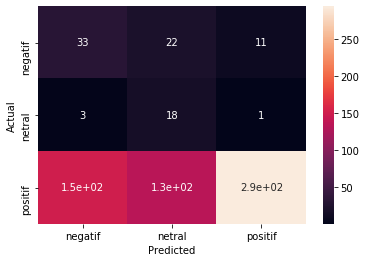

In [20]:
import seaborn as sn

confusion = pd.crosstab(y_test, predictions, rownames=['Actual'], colnames=['Predicted'])

sn.heatmap(confusion, annot=True)

In [21]:
# Create XGB Classifier object
xgb_clf = xgb.XGBClassifier(tree_method = "exact", predictor = "gpu_predictor", verbosity = 1, objective = "multi:softmax")

# Create parameter grid
# parameters = {"learning_rate": [0.1, 0.01, 0.001],
#                "gamma" : [0.01, 0.1, 0.3, 0.5, 1, 1.5, 2],
#                "max_depth": [2, 4, 7, 10],
#                "colsample_bytree": [0.3, 0.6, 0.8, 1.0],
#                "subsample": [0.2, 0.4, 0.5, 0.6, 0.7],
#                "reg_alpha": [0, 0.5, 1],
#                "reg_lambda": [1, 1.5, 2, 3, 4.5],
#                "min_child_weight": [1, 3, 5, 7],
#                "n_estimators": [100, 250, 500, 1000]}

parameters = {"learning_rate": [0.001, 0.01, 0.1, 0.4],
               "gamma" : [0.01, 0.1, 0.3, 0.5, 1, 1.5, 2],
               "max_depth": [2, 4, 7, 10, 12],
               "colsample_bytree": [0.3, 0.6, 0.8, 1.0],
               "subsample": [0.2, 0.4, 0.5, 0.6, 0.7],
               "reg_alpha": [0.001, 0.01, 0.025, 0.5, 1],
               "reg_lambda": [1, 1.5, 2, 3, 4.5],
               "min_child_weight": [1, 3, 5, 7],
               "n_estimators": [100, 250, 500, 1000]}

from sklearn.model_selection import RandomizedSearchCV
# Create RandomizedSearchCV Object
xgb_rscv = RandomizedSearchCV(xgb_clf, param_distributions = parameters, scoring = "f1_micro",
                             cv = 10, verbose = 3, random_state = 40 )
           
# Fit the model
model_xgboost = xgb_rscv.fit(X_train_vector, y_train)

# Model best estimators
print("Learning Rate: ", model_xgboost.best_estimator_.get_params()["learning_rate"])
print("Gamma: ", model_xgboost.best_estimator_.get_params()["gamma"])
print("Max Depth: ", model_xgboost.best_estimator_.get_params()["max_depth"])
print("Subsample: ", model_xgboost.best_estimator_.get_params()["subsample"])
print("Colsample Bytree: ", model_xgboost.best_estimator_.get_params()["colsample_bytree"])
print("Alpha: ", model_xgboost.best_estimator_.get_params()["reg_alpha"])
print("Lamda: ", model_xgboost.best_estimator_.get_params()["reg_lambda"])
print("Min Child Weight: ", model_xgboost.best_estimator_.get_params()["min_child_weight"])
print("Number of Trees: ", model_xgboost.best_estimator_.get_params()["n_estimators"])

Fitting 10 folds for each of 10 candidates, totalling 100 fits
[CV] subsample=0.7, reg_lambda=1.5, reg_alpha=0.01, n_estimators=250, min_child_weight=5, max_depth=10, learning_rate=0.01, gamma=2, colsample_bytree=0.8 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  subsample=0.7, reg_lambda=1.5, reg_alpha=0.01, n_estimators=250, min_child_weight=5, max_depth=10, learning_rate=0.01, gamma=2, colsample_bytree=0.8, score=0.667, total=   3.7s
[CV] subsample=0.7, reg_lambda=1.5, reg_alpha=0.01, n_estimators=250, min_child_weight=5, max_depth=10, learning_rate=0.01, gamma=2, colsample_bytree=0.8 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.6s remaining:    0.0s


[CV]  subsample=0.7, reg_lambda=1.5, reg_alpha=0.01, n_estimators=250, min_child_weight=5, max_depth=10, learning_rate=0.01, gamma=2, colsample_bytree=0.8, score=0.481, total=   2.2s
[CV] subsample=0.7, reg_lambda=1.5, reg_alpha=0.01, n_estimators=250, min_child_weight=5, max_depth=10, learning_rate=0.01, gamma=2, colsample_bytree=0.8 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    5.7s remaining:    0.0s


[CV]  subsample=0.7, reg_lambda=1.5, reg_alpha=0.01, n_estimators=250, min_child_weight=5, max_depth=10, learning_rate=0.01, gamma=2, colsample_bytree=0.8, score=0.704, total=   2.2s
[CV] subsample=0.7, reg_lambda=1.5, reg_alpha=0.01, n_estimators=250, min_child_weight=5, max_depth=10, learning_rate=0.01, gamma=2, colsample_bytree=0.8 
[CV]  subsample=0.7, reg_lambda=1.5, reg_alpha=0.01, n_estimators=250, min_child_weight=5, max_depth=10, learning_rate=0.01, gamma=2, colsample_bytree=0.8, score=0.481, total=   2.1s
[CV] subsample=0.7, reg_lambda=1.5, reg_alpha=0.01, n_estimators=250, min_child_weight=5, max_depth=10, learning_rate=0.01, gamma=2, colsample_bytree=0.8 
[CV]  subsample=0.7, reg_lambda=1.5, reg_alpha=0.01, n_estimators=250, min_child_weight=5, max_depth=10, learning_rate=0.01, gamma=2, colsample_bytree=0.8, score=0.577, total=   1.9s
[CV] subsample=0.7, reg_lambda=1.5, reg_alpha=0.01, n_estimators=250, min_child_weight=5, max_depth=10, learning_rate=0.01, gamma=2, colsampl

[CV]  subsample=0.7, reg_lambda=3, reg_alpha=1, n_estimators=500, min_child_weight=1, max_depth=7, learning_rate=0.4, gamma=0.3, colsample_bytree=0.3, score=0.731, total=   3.2s
[CV] subsample=0.7, reg_lambda=3, reg_alpha=1, n_estimators=500, min_child_weight=1, max_depth=7, learning_rate=0.4, gamma=0.3, colsample_bytree=0.3 
[CV]  subsample=0.7, reg_lambda=3, reg_alpha=1, n_estimators=500, min_child_weight=1, max_depth=7, learning_rate=0.4, gamma=0.3, colsample_bytree=0.3, score=0.308, total=   3.1s
[CV] subsample=0.7, reg_lambda=3, reg_alpha=1, n_estimators=500, min_child_weight=1, max_depth=7, learning_rate=0.4, gamma=0.3, colsample_bytree=0.3 
[CV]  subsample=0.7, reg_lambda=3, reg_alpha=1, n_estimators=500, min_child_weight=1, max_depth=7, learning_rate=0.4, gamma=0.3, colsample_bytree=0.3, score=0.385, total=   3.1s
[CV] subsample=0.5, reg_lambda=3, reg_alpha=0.001, n_estimators=1000, min_child_weight=3, max_depth=10, learning_rate=0.1, gamma=0.3, colsample_bytree=0.8 
[CV]  subs

[CV]  subsample=0.4, reg_lambda=2, reg_alpha=0.01, n_estimators=1000, min_child_weight=3, max_depth=12, learning_rate=0.01, gamma=0.5, colsample_bytree=0.3, score=0.778, total=   4.5s
[CV] subsample=0.4, reg_lambda=2, reg_alpha=0.01, n_estimators=1000, min_child_weight=3, max_depth=12, learning_rate=0.01, gamma=0.5, colsample_bytree=0.3 
[CV]  subsample=0.4, reg_lambda=2, reg_alpha=0.01, n_estimators=1000, min_child_weight=3, max_depth=12, learning_rate=0.01, gamma=0.5, colsample_bytree=0.3, score=0.519, total=   4.5s
[CV] subsample=0.4, reg_lambda=2, reg_alpha=0.01, n_estimators=1000, min_child_weight=3, max_depth=12, learning_rate=0.01, gamma=0.5, colsample_bytree=0.3 
[CV]  subsample=0.4, reg_lambda=2, reg_alpha=0.01, n_estimators=1000, min_child_weight=3, max_depth=12, learning_rate=0.01, gamma=0.5, colsample_bytree=0.3, score=0.615, total=   4.7s
[CV] subsample=0.4, reg_lambda=2, reg_alpha=0.01, n_estimators=1000, min_child_weight=3, max_depth=12, learning_rate=0.01, gamma=0.5, co

[CV]  subsample=0.5, reg_lambda=1.5, reg_alpha=1, n_estimators=500, min_child_weight=3, max_depth=10, learning_rate=0.001, gamma=0.1, colsample_bytree=1.0, score=0.654, total=   6.9s
[CV] subsample=0.5, reg_lambda=1.5, reg_alpha=1, n_estimators=500, min_child_weight=3, max_depth=10, learning_rate=0.001, gamma=0.1, colsample_bytree=1.0 
[CV]  subsample=0.5, reg_lambda=1.5, reg_alpha=1, n_estimators=500, min_child_weight=3, max_depth=10, learning_rate=0.001, gamma=0.1, colsample_bytree=1.0, score=0.385, total=   5.3s
[CV] subsample=0.5, reg_lambda=1.5, reg_alpha=1, n_estimators=500, min_child_weight=3, max_depth=10, learning_rate=0.001, gamma=0.1, colsample_bytree=1.0 
[CV]  subsample=0.5, reg_lambda=1.5, reg_alpha=1, n_estimators=500, min_child_weight=3, max_depth=10, learning_rate=0.001, gamma=0.1, colsample_bytree=1.0, score=0.423, total=   5.0s
[CV] subsample=0.6, reg_lambda=1, reg_alpha=0.01, n_estimators=100, min_child_weight=3, max_depth=2, learning_rate=0.01, gamma=0.01, colsampl

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  4.6min finished


Learning Rate:  0.01
Gamma:  0.5
Max Depth:  12
Subsample:  0.4
Colsample Bytree:  0.3
Alpha:  0.01
Lamda:  2
Min Child Weight:  3
Number of Trees:  1000
